In [1]:
import os
import sys

import xarray as xr
import numpy as np
import zarr

import pandas as pd

import dask

import s3fs
import gcsfs
import boto3

import math

from shapely import geometry

import tqdm

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

import seaborn as sns

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

import cloudpickle


sys.path.append('../analysis/physiology/')
import tpc

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:45689 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 132.82 GB


# Use Generalized TPC to extrapolate performance geographically

In [`./physiology/TPC_params_latitudinal_generalization.ipynb`](./physiology/TPC_params_latitudinal_generalization.ipynb) we develop models to characterize the relationship between latitude and $T_\mathrm{opt}$,  $T_\mathrm{min}$, and $T_\mathrm{max}$ in an effort to parameterize a general thermal performance curve function developed by [Deutsch *et al.* 2008](https://www.pnas.org/content/105/18/6668). 

In the above notebook we generate a `GeneralizedTPC` class and instantiate it with the models of Topt, Tmin, and Tmax derived from the data. This instantiation is saved into `./physiology/gtpc_modeled.pkl`, which we load here: 

In [3]:
with open("./physiology/gtpc_modeled.pkl", 'rb') as f:
    gtpc = cloudpickle.load(f)

## An Example: 

At $45^\circ$ latitude:

In [4]:
latitude = 25
topt, tmin, tmax = gtpc.getTPCParameters(latitude)
tpc = gtpc.getLatitudinalTPC(latitude)

Text(0.5, 1.0, 'Latitude: $25^\\circ$')

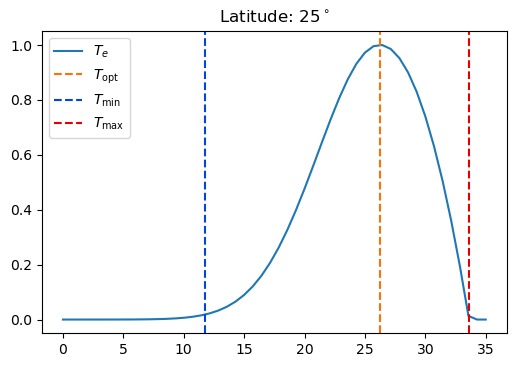

In [5]:
plt.figure(dpi=100)
T = np.linspace(0, 35)
T_e = tpc(T)
plt.plot(T, T_e, label=R'$T_e$')
plt.axvline(topt, color='xkcd:orange', linestyle='--', label=r'$T_\mathrm{opt}$')
plt.axvline(tmin, color='xkcd:blue', linestyle='--', label=r'$T_\mathrm{min}$')
plt.axvline(tmax, color='xkcd:red', linestyle='--', label=r'$T_\mathrm{max}$')
plt.legend()
plt.title(f"Latitude: ${latitude}^\circ$")

## Applied to actual MHWs 

Load MHWs + SST: 

In [4]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')
# Slice to PNW
PNW_LAT = slice(30, 60)
PNW_LON = slice(-155.9, -120.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).compute()
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/new_with_climatology", s3=awsfs)
mhws = xr.open_zarr(mhw_mapper, consolidated=True)
mhws = mhws.chunk({
    'lat': 100, 
    'lon' : 100, 
    'time': 500
})

In [5]:
## Set up Plotting
CENTRAL_LONGITUDE = ((mhws.lon.max() + mhws.lon.min()) / 2).values
CENTRAL_LATITUDE = ((mhws.lat.max() + mhws.lat.min()) / 2).values
PLOT_MAP_PROJECTION = ccrs.Stereographic(central_longitude=CENTRAL_LONGITUDE)
extent = [
    oisst_pnw.lon.min().values,
    oisst_pnw.lon.max().values,
    oisst_pnw.lat.min().values,
    oisst_pnw.lat.max().values

]

### Compute Performance Latitudinally

In [9]:
performance = xr.full_like(oisst_pnw, fill_value=0.).rename_vars({'sst' : "performance"})
performance['performance_clim'] = xr.zeros_like(performance.performance)
performance['topt'] = xr.zeros_like(performance.performance)
performance['tmin'] = xr.zeros_like(performance.performance)
performance['tmax'] = xr.zeros_like(performance.performance)
performance.attrs = {}



In [ ]:
for lat in tqdm.tqdm(performance.lat.values):
    latitude = lat.copy()
    _tpc = gtpc.getLatitudinalTPC(lat)
    _topt, _tmin, _tmax = gtpc.getTPCParameters(lat)
    values = xr.apply_ufunc(
        _tpc,
        oisst_pnw.sel(lat = lat).chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).compute().sst.T
    
    values_clim = xr.apply_ufunc(
        _tpc,
        mhws.clim_seas.sel(lat = lat).chunk({'time': -1}),
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=['float64']
    ).compute().T
    
    performance['performance'].loc[
        dict(lat = lat)
    ] = values
    
    performance['performance_clim'].loc[
        dict(lat = lat)
    ] = values_clim
    
    
    performance['topt'].loc[
        dict(lat = lat)
    ] = _topt
    
    performance['tmin'].loc[
        dict(lat = lat)
    ] = _tmin
    
    performance['tmax'].loc[
        dict(lat = lat)
    ] = _tmax
    
    

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [15]:
performance.to_netcdf("pnw_performance.nc")

In [5]:
performance = xr.open_dataset("pnw_performance.nc")

## Check via Plotting

In [13]:
timeRange = slice('2000', '2016')
thisPerformance = performance.sel(time=timeRange)

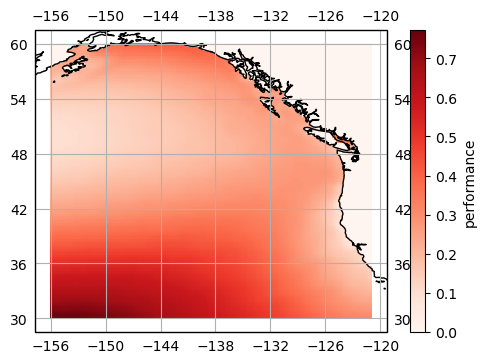

In [14]:
fig = plt.figure(dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
thisPerformance.mean(dim='time').performance.plot(ax=ax, cmap='Reds', transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical', 'coastline', '50m'), facecolor='none', edgecolor='k')
ax.gridlines(draw_labels=True)

In [6]:
small_region = {
    'lon' : slice(-156, -150),
    'lat': slice(30, 36)
}

In [7]:
performance_detriment = 1 - thisPerformance.performance
performance_detriment_clim = 1 - thisPerformance.performance_clim
detriment_ratio = performance_detriment / performance_detriment_clim

NameError: name 'thisPerformance' is not defined

In [ ]:
plt.figure(dpi=100)
performance_detriment.mean(['lat', 'lon']).plot(label='Detriment – SST')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Detriment – Clim')
plt.legend()
plt.xlim(['2014', '2015'])

(735234.0, 735599.0)

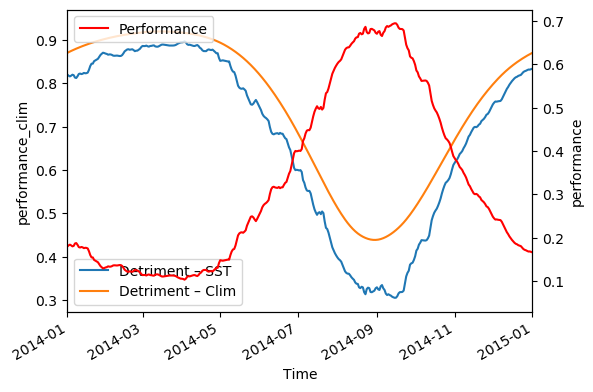

In [19]:
plt.figure(dpi=100)
performance_detriment.mean(['lat', 'lon']).plot(label='Detriment – SST')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Detriment – Clim')
plt.legend()
ax2 = plt.twinx()
(thisPerformance.performance).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Performance')
plt.legend()
plt.xlim(['2014', '2015'])

(735234.0, 735599.0)

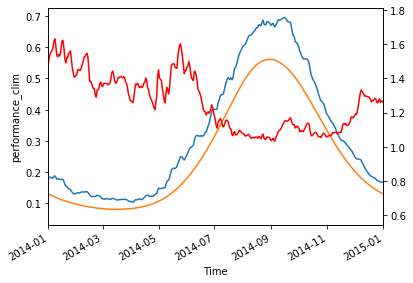

In [64]:
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red')

plt.xlim(['2014', '2015'])

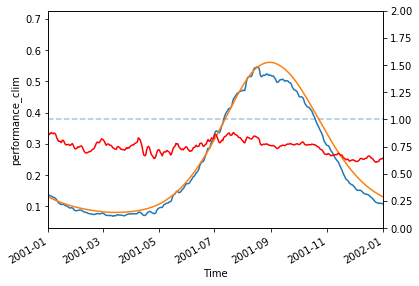

In [20]:
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red')
ax2.set_ylim(0, 2)
plt.xlim(['2001', '2002'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)

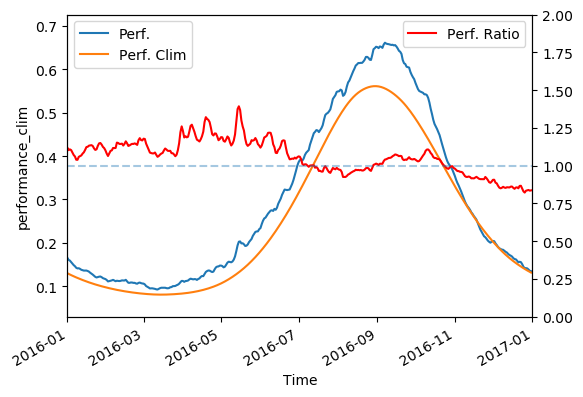

In [21]:
plt.figure(dpi=100)
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
plt.legend()

ax2 = plt.twinx()
(thisPerformance.performance / thisPerformance.performance_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Perf. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


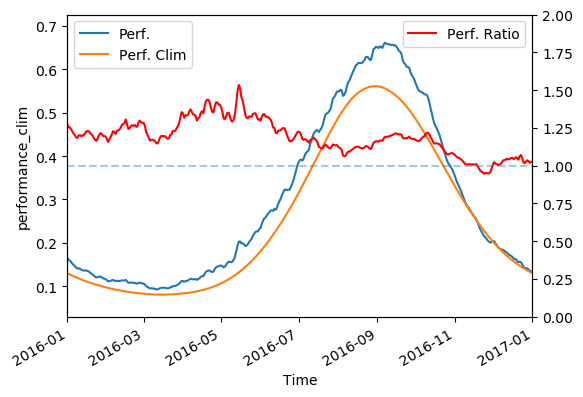

In [96]:
plt.figure(dpi=100)
thisPerformance.performance.mean(dim=['lat', 'lon']).plot(label='Perf.')
thisPerformance.performance_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Clim')
plt.legend()

ax2 = plt.twinx()
(thisPerformance.performance.mean(dim=['lat', 'lon']) / thisPerformance.performance_clim.mean(dim=['lat', 'lon'])).plot(ax=ax2, color='red', label='Perf. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


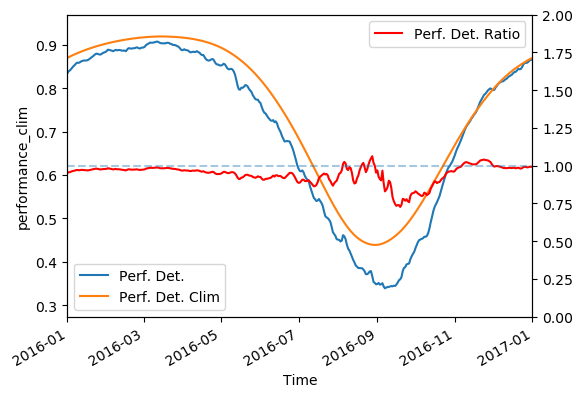

In [67]:
plt.figure(dpi=100)
performance_detriment.mean(dim=['lat', 'lon']).plot(label='Perf. Det.')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Det. Clim')
plt.legend()

ax2 = plt.twinx()
(performance_detriment / performance_detriment_clim).mean(dim=['lat', 'lon']).plot(ax=ax2, color='red', label='Perf. Det. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2016', '2017'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


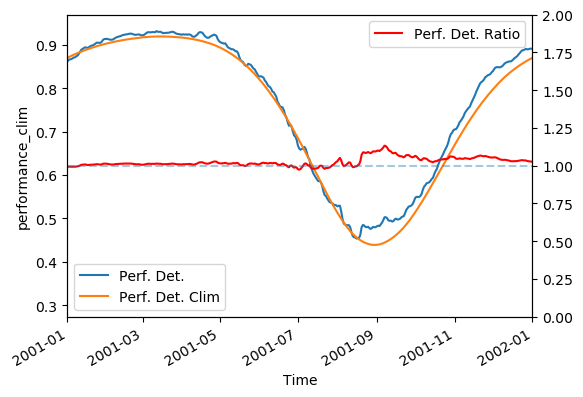

In [91]:
plt.figure(dpi=100)
performance_detriment.mean(dim=['lat', 'lon']).plot(label='Perf. Det.')
performance_detriment_clim.mean(dim=['lat', 'lon']).plot(label='Perf. Det. Clim')
plt.legend()

ax2 = plt.twinx()
(performance_detriment.mean(dim=['lat', 'lon']) / performance_detriment_clim.mean(dim=['lat', 'lon'])).plot(ax=ax2, color='red', label='Perf. Det. Ratio')
ax2.set_ylim(0, 2)
plt.xlim(['2001', '2002'])
ax2.axhline(1.0, linestyle='--', alpha=0.4)
ax2.legend(loc=0)


Discovered an issue here where computing the detriment shows decently different values if it's computed mean first  or mean second

## What's the relationship between perofrmance detriment ratio and MHWs?

In [12]:
DURATION_THRESHOLD = 20
mhw_only_filter = (mhws.mhw !=0) & (mhws.duration >= DURATION_THRESHOLD)
non_mhw_filter = ~mhw_only_filter

In [13]:
performance_merged = xr.merge([performance, mhws], join='inner')

In [48]:
performance_mhw = performance_merged.where(mhw_only_filter & (performance_merged.time.dt.year > 2000), drop=True)

In [15]:
performance_mhw = performance_mhw.sel(**small_region)

In [16]:
pf_df = performance_mhw.to_dataframe().reset_index()

In [49]:
pf_ddf = performance_mhw.to_dask_dataframe()

In [85]:
def compute_mhw_performance(df):
    return pd.Series({
        'detriment_sum' : (1 - df.performance).sum(),
        'detriment_mean' : (1 - df.performance).mean(),
        'performance_diff_sum' : (df.performance - df.performance_clim).sum(),
        'performance_ratio_mean' : (df.performance / df.performance_clim).mean(),
        'intensity_cumulative' : df.intensity_cumulative.min(),
        'duration' : df.duration.min(),
        'start_doy' : df.time.dt.dayofyear.min(),
        'perf_det_ratio' : ((1-df.performance) / (1-df.performance_clim)).mean()
    })


In [86]:
%%time
a = pf_ddf.groupby(['lat', 'lon', 'mhw']).apply(compute_mhw_performance).compute()

/home/ec2-user/miniconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  """Entry point for launching an IPython kernel.


CPU times: user 1min 33s, sys: 6.42 s, total: 1min 39s
Wall time: 6min 17s


In [87]:
a

detriment_sum  detriment_mean  performance_diff_sum  \
lat    lon      mhw                                                         
30.125 -155.625 75.0       2.033229        0.023370             -1.516461   
       -153.625 48.0       9.840485        0.339327              5.823262   
       -152.875 63.0       0.657757        0.017309             -0.374905   
       -152.625 58.0       0.651159        0.016696             -0.332196   
       -149.625 58.0       0.225531        0.006095              0.518095   
...                             ...             ...                   ...   
59.875 -144.875 40.0      29.637877        0.759946              4.320305   
       -143.125 46.0      35.658371        0.775182              4.520249   
       -142.875 55.0      49.303169        0.782590              6.926913   
       -141.625 61.0       0.243869        0.010161              2.706774   
       -139.625 37.0       0.442137        0.009825              6.062724   

                      performance_ratio_mean  intensity_cumulative  duration  \
lat    lon      mhw                                                            
30.125 -155.625 75.0                0.982585            133.096504      88.0   
       -153.625 48.0                1.437657             51.308001      30.0   
       -152.875 63.0                0.990081             59.385146      39.0   
       -152.625 58.0                0.991434             61.383189      40.0   
       -149.625 58.0                1.014356             58.239535      38.0   
...                                      ...                   ...       ...   
59.875 -144.875 40.0                1.855245             63.556233      40.0   
       -143.125 46.0                1.787107             69.403033      47.0   
       -142.875 55.0                2.033732            112.215273      64.0   
       -141.625 61.0                1.128606             47.165760      25.0   
       -139.625 37.0                1.158003            119.151599      46.0   

                      start_doy  \
lat    lon      mhw               
30.125 -155.625 75.0        201   
       -153.625 48.0         25   
       -152.875 63.0        217   
       -152.625 58.0        217   
       -149.625 58.0        219   
...                         ...   
59.875 -144.875 40.0          1   
       -143.125 46.0          4   
       -142.875 55.0         57   
       -141.625 61.0        209   
       -139.625 37.0        196   

                                                         perf_det_ratio  
lat    lon      mhw                                                      
30.125 -155.625 75.0  89674299     0.059405
89674300     0.159351
89...  
       -153.625 48.0  89674299    0.584561
89674300    0.597517
8967...  
       -152.875 63.0  89674299    0.293497
89674300    0.364188
8967...  
       -152.625 58.0  89674299    0.159263
89674300    0.314722
8967...  
       -149.625 58.0  89674299    0.000391
89674300    0.001435
8967...  
...                                                                 ...  
59.875 -144.875 40.0  89713769    0.813958
89713770    0.776917
8971...  
       -143.125 46.0  89713769    0.879296
89713770    0.869783
8971...  
       -142.875 55.0  89713769    0.946766
89713770    0.936119
8971...  
       -141.625 61.0  89713769    0.144259
89713770    0.034227
8971...  
       -139.625 37.0  89713769    0.133568
89713770    0.036028
8971...  

[143734 rows x 8 columns]

In [88]:
a['doy_bin'] = pd.cut(a['start_doy'], 4)

In [91]:
a = a.reset_index()

In [92]:
a['latbins'] = pd.cut(a['lat'], 20)

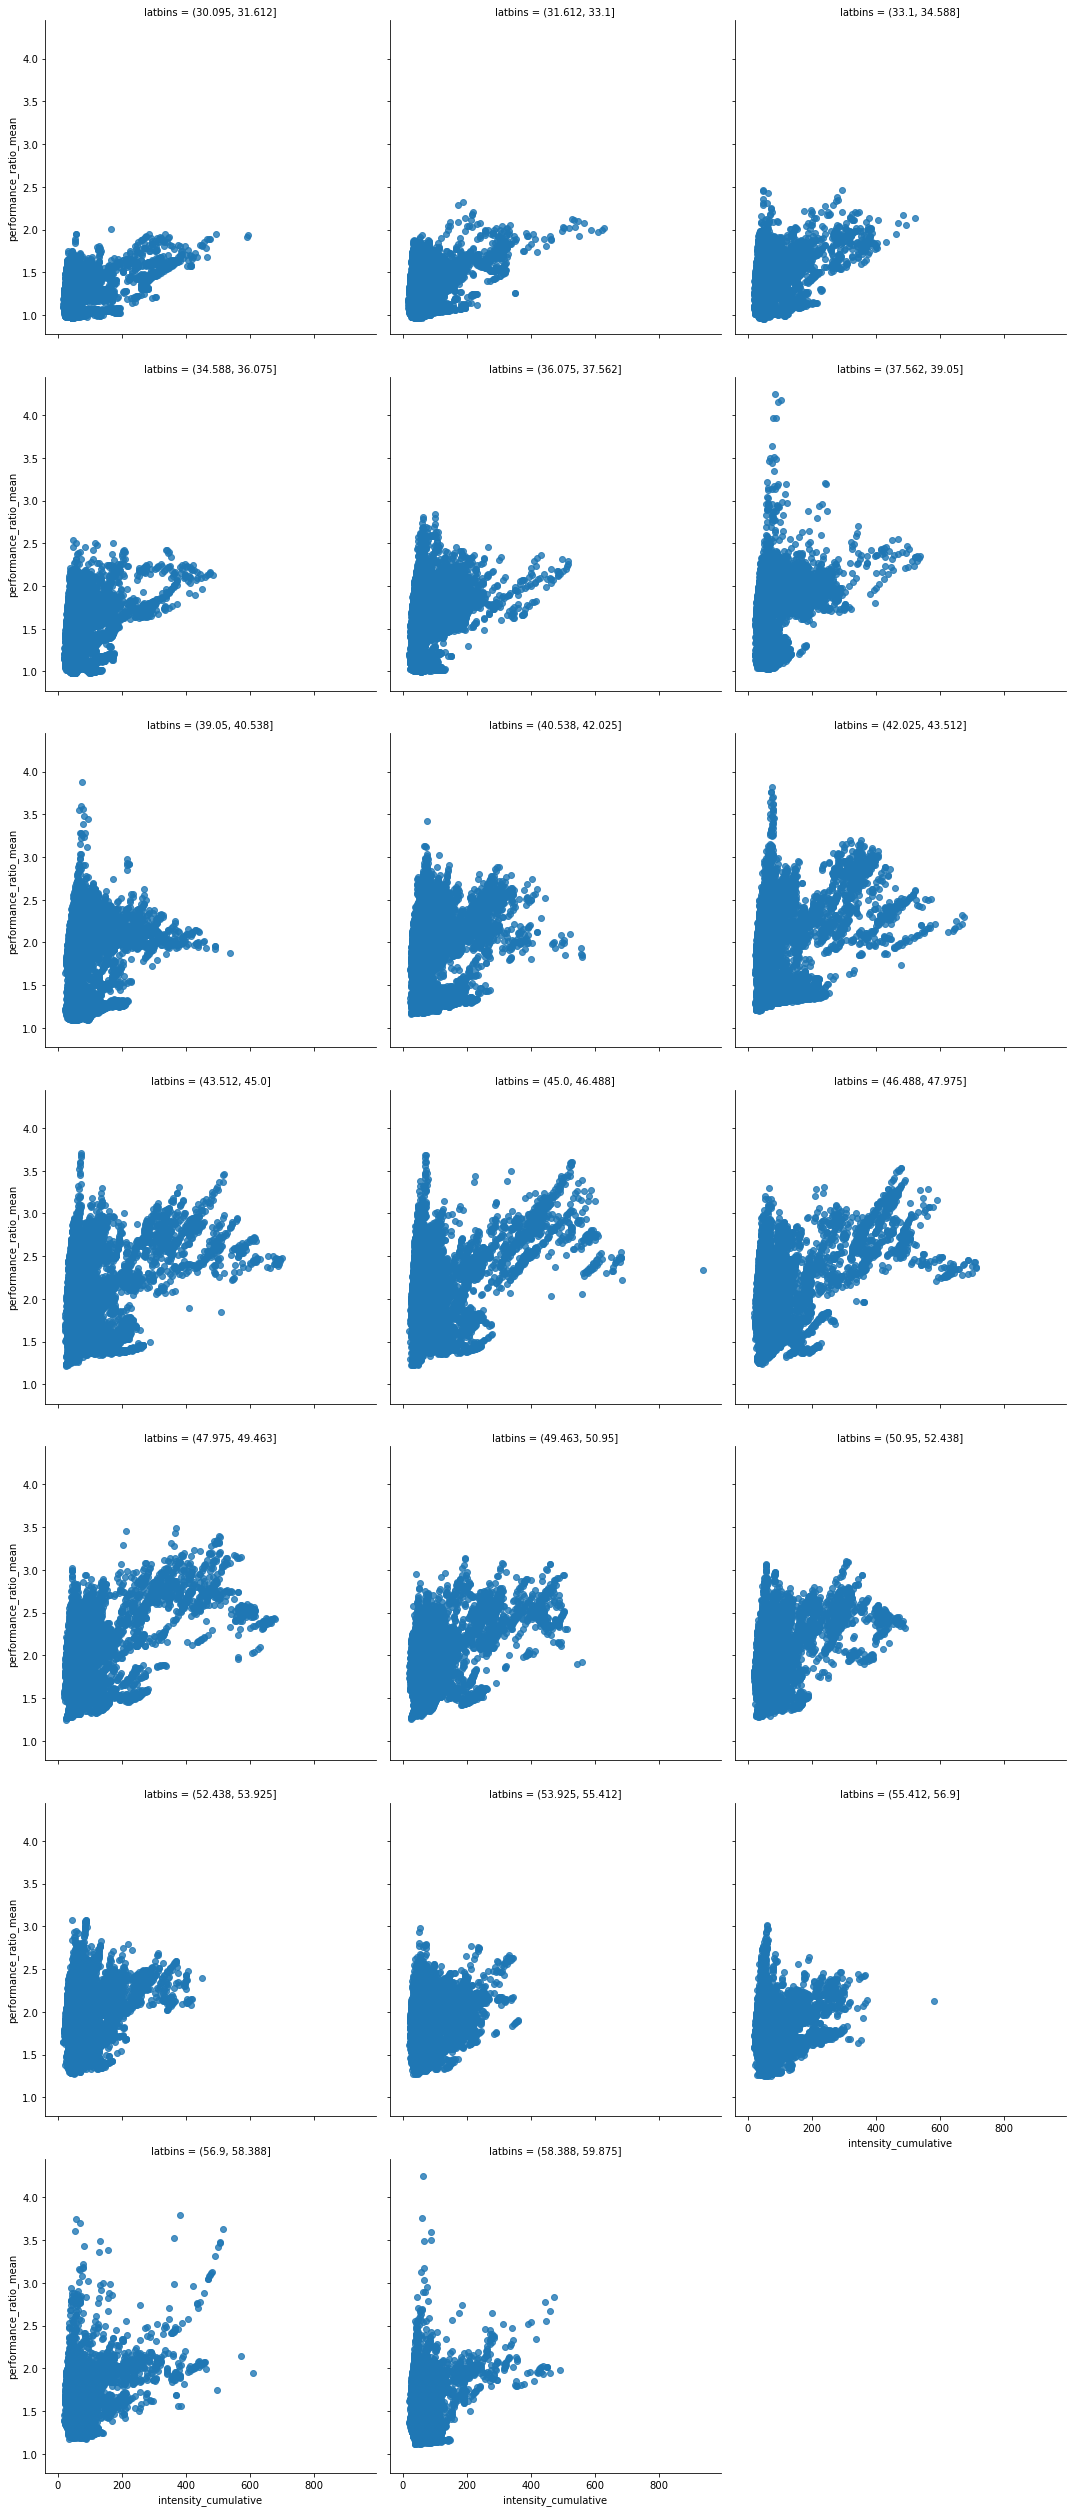

In [96]:
sns.lmplot(x = 'intensity_cumulative', y = 'performance_ratio_mean', data = a, col='latbins', col_wrap=3, fit_reg=False)

In [63]:
ddf = pd.concat([a.rename('perfdiff'), dur.rename('duration')], axis=1)

In [17]:
pf_df = pf_df.dropna(axis=0)

In [64]:
ddf

perfdiff  duration
lat    lon      mhw                     
30.125 -155.625 75.0 -1.516461      88.0
       -153.625 48.0  5.823262      30.0
       -152.875 63.0 -0.374905      39.0
       -152.625 58.0 -0.332196      40.0
       -149.625 58.0  0.518095      38.0
...                        ...       ...
59.875 -144.875 40.0  4.320305      40.0
       -143.125 46.0  4.520249      47.0
       -142.875 55.0  6.926913      64.0
       -141.625 61.0  2.706774      25.0
       -139.625 37.0  6.062724      46.0

[143734 rows x 2 columns]

In [18]:
pf_df.columns

Index(['lat', 'lon', 'time', 'performance', 'performance_clim', 'topt', 'tmin',
       'tmax', 'clim_seas', 'clim_thresh', 'duration', 'index_end',
       'index_peak', 'index_start', 'intensity_cumulative', 'intensity_max',
       'intensity_mean', 'intensity_var', 'mhw', 'rate_decline', 'rate_onset'],
      dtype='object')

In [19]:
# pf_df_recent = pf_df[pf_df.time > '2000']

In [20]:
mhw_groups = pf_df.groupby(['lat', 'lon', 'mhw'])

In [21]:
cell_evented_mhws_perf_det = mhw_groups.apply(lambda x: (1 - x.performance).sum())
cell_evented_mhws_perf_det_scaled = mhw_groups.apply(lambda x: (1 - x.performance).mean())


In [43]:
%%time
cell_evented_mhws_perf_diff = mhw_groups.apply(lambda x: (x.performance - x.performance_clim).sum())

CPU times: user 3.79 s, sys: 294 ms, total: 4.08 s
Wall time: 3.81 s


In [23]:
cell_evented_mhws_perf_ratio = mhw_groups.apply(lambda x: (x.performance / x.performance_clim).mean())

In [24]:
cell_evented_mhws_intense = mhw_groups.apply(lambda x: x.intensity_cumulative.min())
cell_evented_mhws_duration = mhw_groups.apply(lambda x: x.duration.min())
cell_evented_mhws_start = mhw_groups.apply(lambda x: x.time.dt.dayofyear.min())

In [25]:
cell_evented_prf_det_ratio_mean = mhw_groups.apply(lambda x: ((1-x.performance)/(1-x.performance_clim)).mean())

In [26]:
evented = pd.concat([
    cell_evented_mhws_intense.rename('intensity'),
    cell_evented_mhws_duration.rename("duration"),
    cell_evented_mhws_start.rename('startdoy'),
    cell_evented_mhws_perf_diff.rename('perf_diff'),
    cell_evented_mhws_perf_det.rename('perf_det'),
    cell_evented_mhws_perf_det_scaled.rename('perf_det_mean'), 
    cell_evented_mhws_perf_ratio.rename('perf_ratio_mean'), 
    cell_evented_prf_det_ratio_mean.rename('perf_det_ratio_mean')
], axis=1)


In [27]:
evented = evented.reset_index()

In [28]:
evented['latbin'] = pd.cut(evented.lat, bins=6)

In [29]:
evented_mhw = evented[evented.mhw > 0]

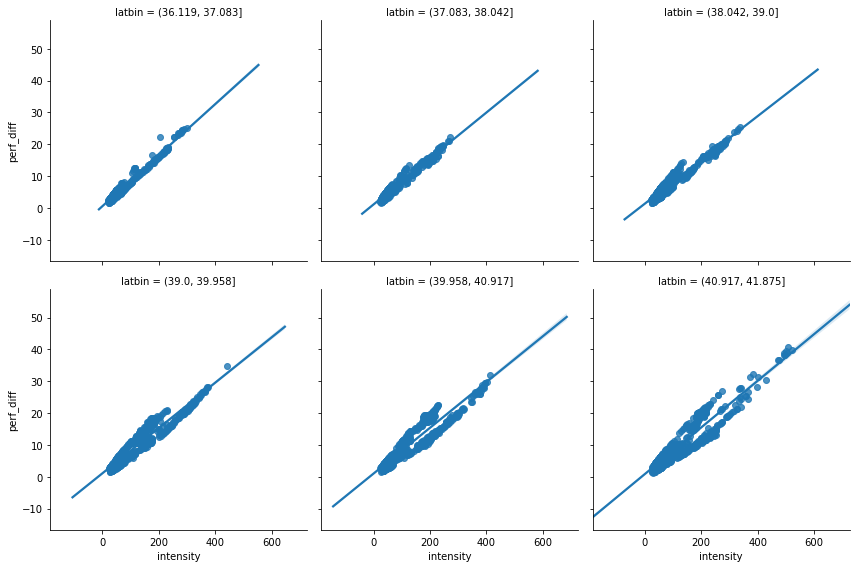

In [44]:
sns.lmplot(x = 'intensity', y = 'perf_diff', height=4, col='latbin', col_wrap=3, data=evented_mhw)

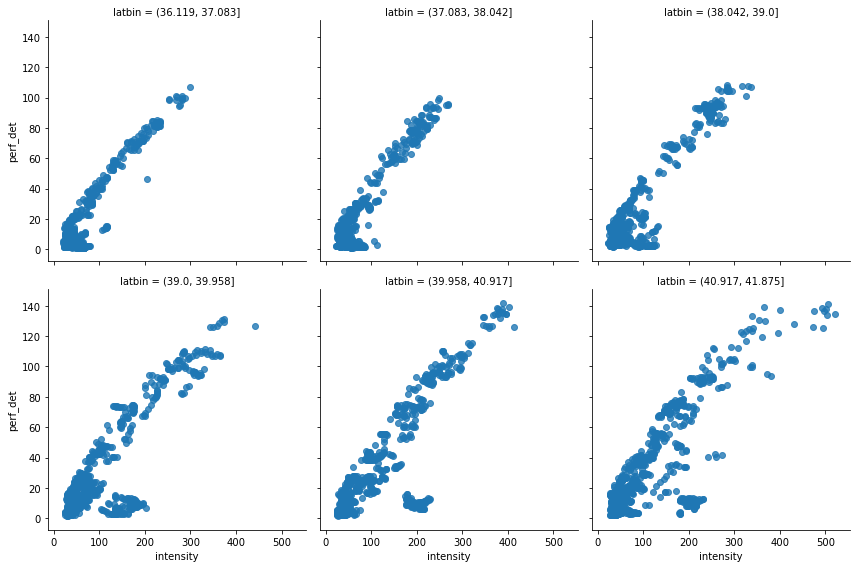

In [45]:
sns.lmplot(x = 'intensity', y = 'perf_det', col='latbin', col_wrap=3, height=4,data=evented_mhw, fit_reg=False, )

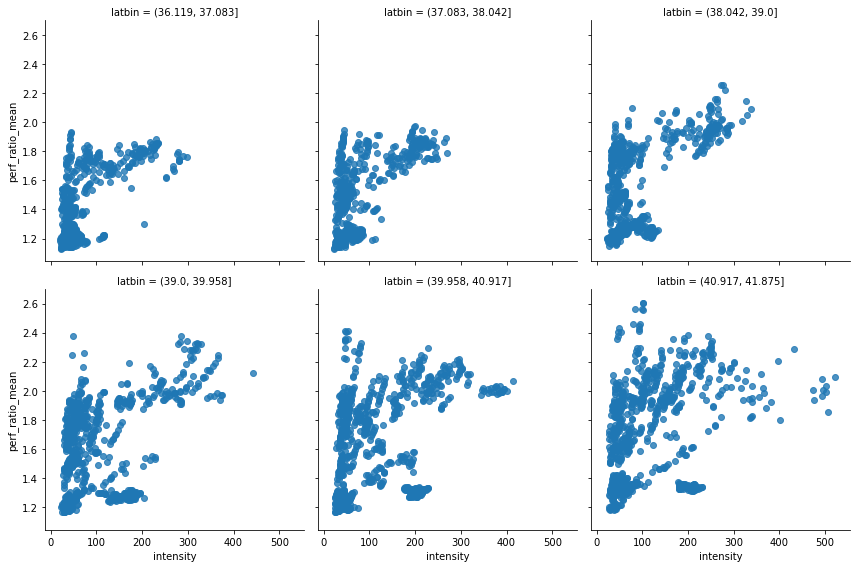

In [46]:
sns.lmplot(x = 'intensity', y = 'perf_ratio_mean', col='latbin', col_wrap=3, height=4,data=evented_mhw, fit_reg=False, )

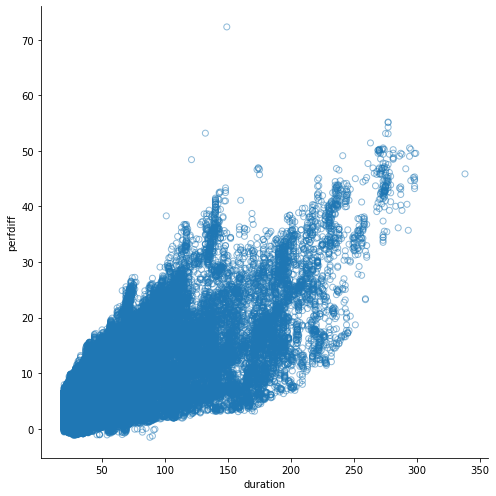

In [67]:
sns.lmplot(
    x = 'duration',
    y = 'perfdiff', 
    height=7,data=ddf, 
    fit_reg=False,
    scatter_kws=dict(facecolors='none', alpha=0.5)
)


In [ ]:
# cmap = sns.cubehelix_palette(dark=0, light=365)
sns.lmplot(x = 'intensity', y = 'perf_det_mean', col='latbin', col_wrap=2, height=7,data=evented_mhw, fit_reg=False, hue='startdoy')

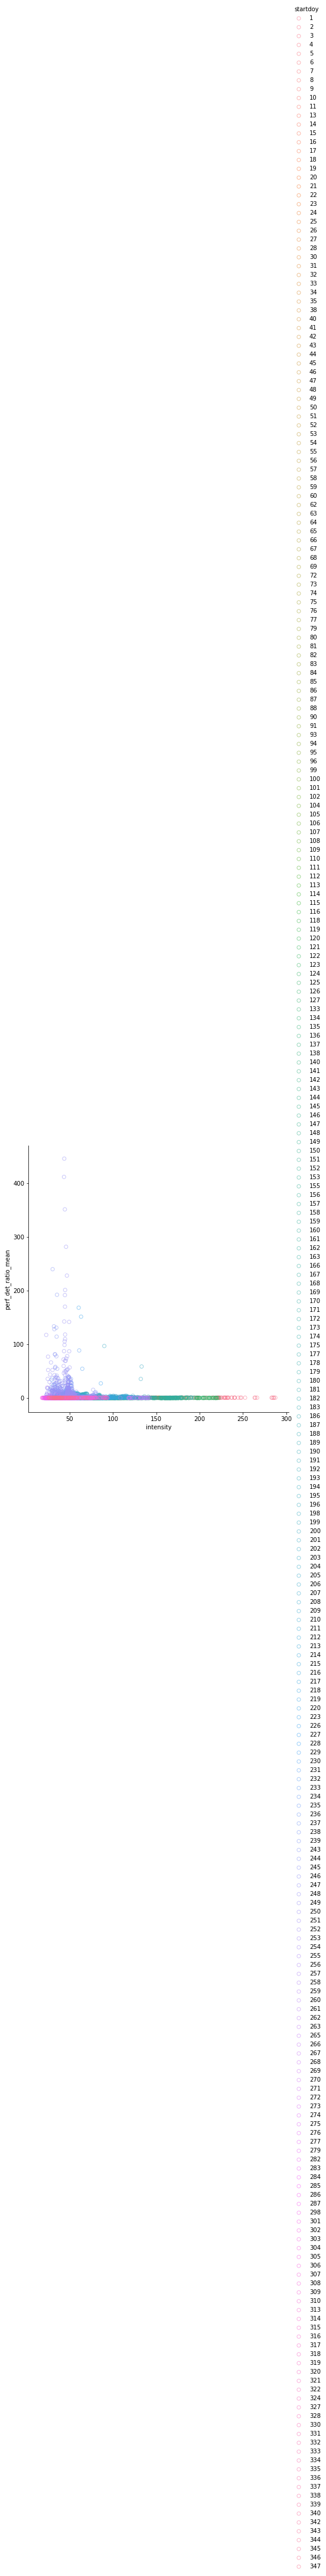

In [31]:
sns.lmplot(
    x = 'intensity', 
    y = 'perf_det_ratio_mean',
    hue = 'startdoy',
    height=7,data=evented_mhw, fit_reg=False, scatter_kws=dict(facecolors='none', alpha=0.5)
)

---

# How often does SST exceed modeled $T_\mathrm{opt}$ ?

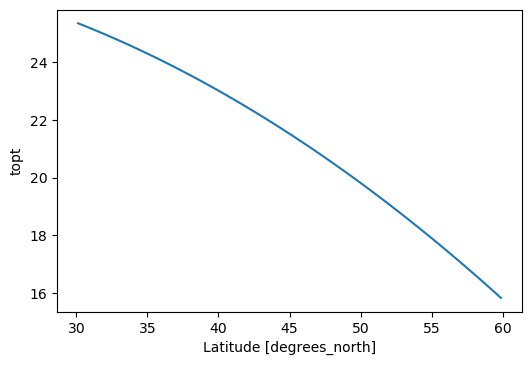

In [48]:
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$')


In [19]:
databounds = {
    'lat': slice(performance.lat.min(), performance.lat.max()),
    'lon': slice(performance.lon.min(), performance.lon.max()),
}

In [66]:
these_sst = oisst.sel(**databounds)

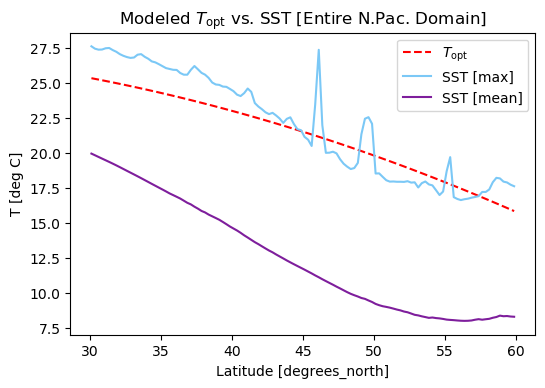

In [67]:
plt.figure(dpi=100)
ax = plt.axes()
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$', ax=ax, color='red', linestyle='--')
these_sst.sst.max(dim=['lon', 'time']).plot(ax=ax, color='xkcd:lightblue', label='SST [max]')
these_sst.sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:purple', label='SST [mean]')
ax.set_ylabel("T [deg C]")
plt.title("Modeled $T_\mathrm{opt}$ vs. SST [Entire N.Pac. Domain]")

plt.legend()

**For small region above..**

In [59]:
these_sst = oisst.sel(**small_region)

In [68]:
print(small_region)

{'lon': slice(-138, -132, None), 'lat': slice(36, 42, None)}


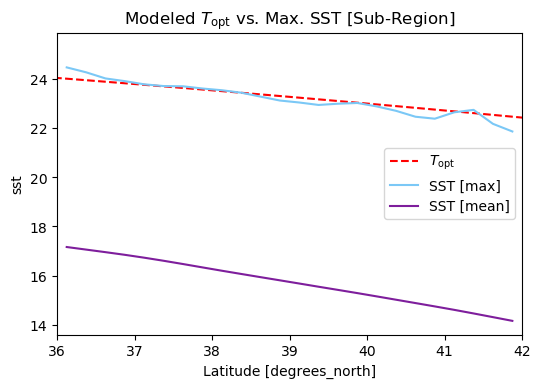

In [65]:
plt.figure(dpi=100)
ax = plt.axes()
performance.topt.max(dim=['lon', 'time']).plot(label='$T_\mathrm{opt}$', ax=ax, color='red', linestyle='--')
ax.set_ylabel("T [deg C]")
these_sst.sst.max(dim=['lon', 'time']).plot(ax=ax, color='xkcd:lightblue', label='SST [max]')
these_sst.sst.mean(dim=['lon', 'time']).plot(ax=ax, color='xkcd:purple', label='SST [mean]')
plt.title("Modeled $T_\mathrm{opt}$ vs. Max. SST [Sub-Region]")
ax.set_xlim([small_region['lat'].start, small_region['lat'].stop])
plt.legend()

---

In [7]:
performance

<xarray.Dataset>
Dimensions:           (lat: 120, lon: 140, time: 13636)
Coordinates:
  * lat               (lat) float32 30.125 30.375 30.625 ... 59.625 59.875
  * lon               (lon) float32 -155.875 -155.625 ... -121.375 -121.125
  * time              (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    performance       (time, lat, lon) float32 ...
    performance_clim  (time, lat, lon) float32 ...
    topt              (time, lat, lon) float32 ...
    tmin              (time, lat, lon) float32 ...
    tmax              (time, lat, lon) float32 ...

In [15]:
mhws.reset_index("time").reset_coords('time_')

,Array,Chunk
Bytes,1.83 GB,40.00 MB
Shape,"(120, 140, 13636)","(100, 100, 500)"
Count,871 Tasks,112 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,1.83 GB,40.00 MB
Shape,"(120, 140, 13636)","(100, 100, 500)"
Count,871 Tasks,112 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [47]:
mhws.set_index(x=['mhw']).stack(s=['lat', 'lon', 'x'])

ValueError: Buffer has wrong number of dimensions (expected 1, got 3)

In [66]:
indexed = mhws.set_coords('mhw').set_index(mhw_index=['mhw'])

In [68]:
grid = mhws.stack(grid=['lat', 'lon']).set_coords('mhw')

In [95]:
grid.isel(grid=slice(5, 6)).to_array()

<xarray.DataArray 'stack-a968fea7856530f6709e1ca125212244' (variable: 12, time: 13636, grid: 1)>
dask.array<stack, shape=(12, 13636, 1), dtype=float64, chunksize=(1, 500, 1), chunktype=numpy.ndarray>
Coordinates:
    mhw       (time, grid) float64 dask.array<chunksize=(500, 1), meta=np.ndarray>
  * time      (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
  * grid      (grid) MultiIndex
  - lat       (grid) float64 30.12
  - lon       (grid) float64 -154.6
  * variable  (variable) <U20 'clim_seas' 'clim_thresh' ... 'rate_onset'